18521492 - Trần Minh Tiến

18520286 - Trần Xuân Hưng

18520471 - Tô Viết Anh

### Download PhoBERT & VNCoreNLP

In [2]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [1]:
cd "/content/drive/MyDrive/Colab Notebooks/phoBERT"

/content/drive/MyDrive/Colab Notebooks/phoBERT


In [ ]:
# !git clone https://github.com/huggingface/transformers

In [ ]:
# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [25]:
!unzip UIT-VSMEC.zip

Archive:  UIT-VSMEC.zip
  inflating: UIT-VSMEC/valid_nor_811.xlsx  
  inflating: UIT-VSMEC/test_nor_811.xlsx  
  inflating: UIT-VSMEC/train_nor_811.xlsx  


In [11]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2021-07-20 14:53:01--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.222.149.2, 52.222.149.57, 52.222.149.21, ...
Connecting to public.vinai.io (public.vinai.io)|52.222.149.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M  16.7MB/s    in 20s     

2021-07-20 14:53:23 (15.1 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


### Pip install requirements

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers"

In [ ]:
pip install .

In [ ]:
!pip install vncorenlp
!pip install fastBPE
!pip install fairseq
!pip install tensorboard --upgrade

### Get VNCoreNLP tokenizer

In [2]:
# Test import
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

text = "Đại học Công Nghệ Thông Tin, đại học quốc gia Hồ Chí Minh."

word_segmented_text = rdrsegmenter.tokenize(text) 
print(word_segmented_text)

[['Đại_học', 'Công_Nghệ_Thông_Tin', ',', 'đại_học', 'quốc_gia', 'Hồ_Chí_Minh', '.']]


### Import Libs & RoBERTa Vocab + BPE Vocab

In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict

from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

import numpy as np
import random
import warnings
import pandas as pd
import gensim
import argparse
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

# Load BPE encoder 
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)

args, unknown = parser.parse_known_args()
bpe = fastBPE(args) 

# Load the dictionary  
vocab = Dictionary()
vocab.add_from_file("/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/dict.txt")

### Dataloader Function

In [4]:
MAX_LEN = 70
device = 'cuda'

def get_dataset(data_path):
  data, labels = [], []
  df = pd.read_excel(data_path, sheet_name=None)
  df = df['Sheet1']
  df.columns = ['index', 'emotion', 'sentence']
  for i in range(len(df)):
    sentence = gensim.utils.simple_preprocess(df['sentence'][i], min_len=1)
    sentence = ' '.join(sentence)
    sentence = rdrsegmenter.tokenize(sentence)
    if sentence != []:
      sentence = ' '.join(sentence[0])
      data.append(sentence)
      labels.append(df['emotion'][i])
  
  data = np.array(data)
  labels = np.array(labels)

  return data, labels

def data_loader_format(data_sentences, labels):
  ids, masks = [], []

  for sent in data_sentences:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    ids.append(encoded_sent)
  
  ids = pad_sequences(ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

  for sent in ids:
    mask = [int(token_id > 0) for token_id in sent]
    masks.append(mask)

  input_ids = torch.tensor(ids)
  input_labels = torch.tensor(labels)
  input_masks = torch.tensor(masks)

  dataset = TensorDataset(input_ids, input_masks, input_labels)
  sampler = SequentialSampler(dataset)
  return DataLoader(dataset, sampler = sampler, batch_size = 32)

### Load data

In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/phoBERT/UIT-VSMEC/train_nor_811.xlsx"
valid_path = "/content/drive/MyDrive/Colab Notebooks/phoBERT/UIT-VSMEC/valid_nor_811.xlsx"
test_path = "/content/drive/MyDrive/Colab Notebooks/phoBERT/UIT-VSMEC/test_nor_811.xlsx"

train_data, train_label = get_dataset(train_path)
valid_data, valid_label = get_dataset(valid_path)
test_data, test_label = get_dataset(test_path)

train_data = np.concatenate((train_data, valid_data), axis = None)
train_label = np.concatenate((train_label, valid_label), axis = None)

lb = LabelEncoder()
lb.fit(train_label)

train_label = lb.transform(train_label)
test_label = lb.transform(test_label)

test_dataloader = data_loader_format(test_data, test_label)

### Prediction Function

In [6]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

def bert_predict(model, dataloader):
  model.eval()
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_f1 = 0
  pred_label = np.array([])
  for batch in tqdm_notebook(dataloader):

      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
          outputs = phobert(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
          logits = outputs[0]
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          loss_fn = torch.nn.CrossEntropyLoss().to(device)
          eval_loss += loss_fn(outputs[0], b_labels)

          preds = np.argmax(logits, axis=1).flatten()
          pred_label = np.concatenate((pred_label,preds), axis = None)

          tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

          eval_accuracy += tmp_eval_accuracy
          eval_f1 += tmp_eval_f1
          nb_eval_steps += 1
  print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
  print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))

  pred_label = np.array(list(map(lambda x: int(x), pred_label)))
  result = [(eval_loss.item()/nb_eval_steps), (eval_accuracy/nb_eval_steps)] # [0: val_loss, 1: val_acc]
  return pred_label, result

### Training

In [10]:
epochs = 5
best_accuracy = 0


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=86)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_label), start = 1):
  print('-'*50)
  print(f'Fold: {fold}')
  fold_train_data = np.array([train_data[x] for x in train_idx ])
  fold_train_label = np.array([train_label[x] for x in train_idx ])

  fold_valid_data = np.array([train_data[x] for x in val_idx ])
  fold_valid_label = np.array([train_label[x] for x in val_idx ])

  train_dataloader = data_loader_format(fold_train_data, fold_train_label)
  val_dataloader = data_loader_format(fold_valid_data, fold_valid_label)

  # Load model
  config = RobertaConfig.from_pretrained(
      "/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/config.json",
      from_tf=False, num_labels = 7, output_hidden_states=False,
  )
  phobert = RobertaForSequenceClassification.from_pretrained(
      "/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin",
      config=config
  )

  phobert.cuda()

  param_optimizer = list(phobert.named_parameters())
  no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

  for epoch_i in range(0, epochs):
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      total_loss = 0
      phobert.train()
      train_accuracy = 0
      nb_train_steps = 0
      train_f1 = 0
      
      for step, batch in tqdm_notebook(enumerate(train_dataloader)):
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          phobert.zero_grad()
          outputs = phobert(b_input_ids, 
              token_type_ids=None, 
              attention_mask=b_input_mask, 
              labels=b_labels)
          
          loss = outputs[0]
          total_loss += loss.item()

          writer.add_scalar("Loss/train", loss.item(), epoch_i)
          
          logits = outputs[1].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)

          writer.add_scalar("Accuracy/train", tmp_train_accuracy, epoch_i)

          train_accuracy += tmp_train_accuracy
          train_f1 += tmp_train_f1
          nb_train_steps += 1
          
          loss.backward()
          torch.nn.utils.clip_grad_norm_(phobert.parameters(), 1.0)
          optimizer.step()
          
      avg_train_loss = total_loss / len(train_dataloader)
      print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
      print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
      print(" Training Loss: {0:.4f}".format(avg_train_loss))

      print("Running Validation...")
      _, val_result = bert_predict(phobert, val_dataloader)
      print(" Validation Loss: {0:.4f}".format(val_result[0]))
      

      if val_result[1] > best_accuracy:
        torch.save(phobert.state_dict(), '/content/drive/My Drive/Colab Notebooks/phoBERT/pytorch_phoBERT_sentiment.bin')
        best_accuracy = val_result[1]


  print("Training complete!")

--------------------------------------------------
Fold: 1



You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.3679
 F1 score: 0.1859
 Training Loss: 1.6492
Running Validation...



 Accuracy: 0.4641
 F1 score: 0.3184
 Validation Loss: 1.4421
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5545
 F1 score: 0.4129
 Training Loss: 1.2496
Running Validation...



 Accuracy: 0.5328
 F1 score: 0.4336
 Validation Loss: 1.2862
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6419
 F1 score: 0.5205
 Training Loss: 1.0137
Running Validation...



 Accuracy: 0.5266
 F1 score: 0.4336
 Validation Loss: 1.3077
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7100
 F1 score: 0.6104
 Training Loss: 0.8493
Running Validation...



 Accuracy: 0.5469
 F1 score: 0.4608
 Validation Loss: 1.3103
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7641
 F1 score: 0.6756
 Training Loss: 0.7112
Running Validation...



 Accuracy: 0.5250
 F1 score: 0.4419
 Validation Loss: 1.3892
Training complete!
--------------------------------------------------
Fold: 2


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.4128
 F1 score: 0.2430
 Training Loss: 1.5411
Running Validation...



 Accuracy: 0.5469
 F1 score: 0.4409
 Validation Loss: 1.2699
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5950
 F1 score: 0.4608
 Training Loss: 1.1367
Running Validation...



 Accuracy: 0.5625
 F1 score: 0.4712
 Validation Loss: 1.1838
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6807
 F1 score: 0.5592
 Training Loss: 0.9256
Running Validation...



 Accuracy: 0.5813
 F1 score: 0.5208
 Validation Loss: 1.1801
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7381
 F1 score: 0.6399
 Training Loss: 0.7765
Running Validation...



 Accuracy: 0.5750
 F1 score: 0.4916
 Validation Loss: 1.2308
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7824
 F1 score: 0.7006
 Training Loss: 0.6559
Running Validation...



 Accuracy: 0.5891
 F1 score: 0.5092
 Validation Loss: 1.2888
Training complete!
--------------------------------------------------
Fold: 3


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.3990
 F1 score: 0.2224
 Training Loss: 1.5627
Running Validation...



 Accuracy: 0.4938
 F1 score: 0.3583
 Validation Loss: 1.3257
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5844
 F1 score: 0.4600
 Training Loss: 1.1704
Running Validation...



 Accuracy: 0.5828
 F1 score: 0.4968
 Validation Loss: 1.1745
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6691
 F1 score: 0.5629
 Training Loss: 0.9546
Running Validation...



 Accuracy: 0.5844
 F1 score: 0.5132
 Validation Loss: 1.1320
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7317
 F1 score: 0.6450
 Training Loss: 0.8045
Running Validation...



 Accuracy: 0.5969
 F1 score: 0.5276
 Validation Loss: 1.1692
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7765
 F1 score: 0.6972
 Training Loss: 0.6703
Running Validation...



 Accuracy: 0.5891
 F1 score: 0.5192
 Validation Loss: 1.2306
Training complete!
--------------------------------------------------
Fold: 4


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.3648
 F1 score: 0.1843
 Training Loss: 1.6422
Running Validation...



 Accuracy: 0.5260
 F1 score: 0.3346
 Validation Loss: 1.3073
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5620
 F1 score: 0.4095
 Training Loss: 1.2233
Running Validation...



 Accuracy: 0.5809
 F1 score: 0.4585
 Validation Loss: 1.1835
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6497
 F1 score: 0.5382
 Training Loss: 0.9930
Running Validation...



 Accuracy: 0.5780
 F1 score: 0.4872
 Validation Loss: 1.1532
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7156
 F1 score: 0.6241
 Training Loss: 0.8289
Running Validation...



 Accuracy: 0.5892
 F1 score: 0.5101
 Validation Loss: 1.1618
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7646
 F1 score: 0.6774
 Training Loss: 0.6980
Running Validation...



 Accuracy: 0.5811
 F1 score: 0.4847
 Validation Loss: 1.2189
Training complete!
--------------------------------------------------
Fold: 5


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.3792
 F1 score: 0.2145
 Training Loss: 1.6121
Running Validation...



 Accuracy: 0.4936
 F1 score: 0.3343
 Validation Loss: 1.3555
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5566
 F1 score: 0.4170
 Training Loss: 1.2328
Running Validation...



 Accuracy: 0.5519
 F1 score: 0.4147
 Validation Loss: 1.2186
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6491
 F1 score: 0.5396
 Training Loss: 1.0028
Running Validation...



 Accuracy: 0.5542
 F1 score: 0.4632
 Validation Loss: 1.2135
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7118
 F1 score: 0.6162
 Training Loss: 0.8378
Running Validation...



 Accuracy: 0.5671
 F1 score: 0.4781
 Validation Loss: 1.2791
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7634
 F1 score: 0.6842
 Training Loss: 0.7045
Running Validation...



 Accuracy: 0.5577
 F1 score: 0.4577
 Validation Loss: 1.3275
Training complete!
--------------------------------------------------
Fold: 6


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.4206
 F1 score: 0.2569
 Training Loss: 1.5334
Running Validation...



 Accuracy: 0.5110
 F1 score: 0.3903
 Validation Loss: 1.2807
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5922
 F1 score: 0.4650
 Training Loss: 1.1507
Running Validation...



 Accuracy: 0.5657
 F1 score: 0.4714
 Validation Loss: 1.1681
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6722
 F1 score: 0.5622
 Training Loss: 0.9537
Running Validation...



 Accuracy: 0.5816
 F1 score: 0.4858
 Validation Loss: 1.1551
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7400
 F1 score: 0.6507
 Training Loss: 0.7920
Running Validation...



 Accuracy: 0.5862
 F1 score: 0.5202
 Validation Loss: 1.1676
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7729
 F1 score: 0.6983
 Training Loss: 0.6834
Running Validation...



 Accuracy: 0.5722
 F1 score: 0.5049
 Validation Loss: 1.2342
Training complete!
--------------------------------------------------
Fold: 7


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.2996
 F1 score: 0.1232
 Training Loss: 1.7497
Running Validation...



 Accuracy: 0.3352
 F1 score: 0.1432
 Validation Loss: 1.6843
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.4342
 F1 score: 0.2691
 Training Loss: 1.5244
Running Validation...



 Accuracy: 0.4751
 F1 score: 0.3082
 Validation Loss: 1.4042
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.5559
 F1 score: 0.4131
 Training Loss: 1.2415
Running Validation...



 Accuracy: 0.5409
 F1 score: 0.4039
 Validation Loss: 1.2643
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.6363
 F1 score: 0.5205
 Training Loss: 1.0404
Running Validation...



 Accuracy: 0.5827
 F1 score: 0.4778
 Validation Loss: 1.1804
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.6994
 F1 score: 0.6007
 Training Loss: 0.8853
Running Validation...



 Accuracy: 0.5829
 F1 score: 0.4755
 Validation Loss: 1.1809
Training complete!
--------------------------------------------------
Fold: 8


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.4199
 F1 score: 0.2547
 Training Loss: 1.5233
Running Validation...



 Accuracy: 0.5534
 F1 score: 0.4114
 Validation Loss: 1.2611
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5952
 F1 score: 0.4667
 Training Loss: 1.1434
Running Validation...



 Accuracy: 0.6052
 F1 score: 0.5144
 Validation Loss: 1.1391
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6720
 F1 score: 0.5662
 Training Loss: 0.9274
Running Validation...



 Accuracy: 0.6206
 F1 score: 0.5514
 Validation Loss: 1.1260
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7444
 F1 score: 0.6549
 Training Loss: 0.7662
Running Validation...



 Accuracy: 0.6177
 F1 score: 0.5421
 Validation Loss: 1.2006
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7810
 F1 score: 0.7034
 Training Loss: 0.6479
Running Validation...



 Accuracy: 0.6175
 F1 score: 0.5514
 Validation Loss: 1.2102
Training complete!
--------------------------------------------------
Fold: 9


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.4284
 F1 score: 0.2504
 Training Loss: 1.5468
Running Validation...



 Accuracy: 0.5458
 F1 score: 0.4051
 Validation Loss: 1.3045
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5836
 F1 score: 0.4441
 Training Loss: 1.1756
Running Validation...



 Accuracy: 0.5800
 F1 score: 0.4642
 Validation Loss: 1.2028
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6557
 F1 score: 0.5390
 Training Loss: 0.9903
Running Validation...



 Accuracy: 0.5845
 F1 score: 0.4938
 Validation Loss: 1.1833
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7147
 F1 score: 0.6072
 Training Loss: 0.8412
Running Validation...



 Accuracy: 0.5856
 F1 score: 0.4969
 Validation Loss: 1.2375
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7579
 F1 score: 0.6685
 Training Loss: 0.7224
Running Validation...



 Accuracy: 0.5954
 F1 score: 0.5063
 Validation Loss: 1.2705
Training complete!
--------------------------------------------------
Fold: 10


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.4124
 F1 score: 0.2388
 Training Loss: 1.5516
Running Validation...



 Accuracy: 0.4915
 F1 score: 0.3525
 Validation Loss: 1.3310
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.5761
 F1 score: 0.4398
 Training Loss: 1.1695
Running Validation...



 Accuracy: 0.5874
 F1 score: 0.4731
 Validation Loss: 1.1361
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.6645
 F1 score: 0.5592
 Training Loss: 0.9644
Running Validation...



 Accuracy: 0.5983
 F1 score: 0.5022
 Validation Loss: 1.1628
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.7314
 F1 score: 0.6400
 Training Loss: 0.8045
Running Validation...



 Accuracy: 0.6233
 F1 score: 0.5455
 Validation Loss: 1.1111
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.7815
 F1 score: 0.7006
 Training Loss: 0.6691
Running Validation...



 Accuracy: 0.6265
 F1 score: 0.5531
 Validation Loss: 1.1374
Training complete!


### Get best model

In [ ]:
config = RobertaConfig.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/phoBERT/transformers/PhoBERT_base_transformers/config.json",
    from_tf=False, num_labels = 7, output_hidden_states=False,
)
phobert = RobertaForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/phoBERT/pytorch_phoBERT_sentiment.bin",
    config=config
)

phobert.cuda()

In [14]:
pred_labels_trained, _ = bert_predict(phobert, test_dataloader)
print(classification_report(test_label, pred_labels_trained, target_names=lb.classes_))


 Accuracy: 0.6241
 F1 score: 0.5847
              precision    recall  f1-score   support

       Anger       0.59      0.40      0.48        40
     Disgust       0.67      0.58      0.62       132
   Enjoyment       0.70      0.70      0.70       193
        Fear       0.77      0.65      0.71        46
       Other       0.44      0.67      0.53       129
     Sadness       0.69      0.58      0.63       116
    Surprise       0.73      0.51      0.60        37

    accuracy                           0.62       693
   macro avg       0.66      0.59      0.61       693
weighted avg       0.65      0.62      0.63       693



### Show Result

In [15]:
arr = []
arr_label = []
for i in range(len(pred_labels_trained)):
  if pred_labels_trained[i] == test_label[i]:
    arr.append(i)
    arr_label.append(pred_labels_trained[i])

for i in range(15):
  print('-'*30)
  print(test_data[arr[i]])
  print("Real_label {} ---vs--- Pred_label {}".format(lb.classes_[test_label[arr[i]]], lb.classes_[pred_labels_trained[arr[i]]]))

------------------------------
kinh vãi
Real_label Disgust ---vs--- Pred_label Disgust
------------------------------
nhà thì không xa lắm nhưng chưa bao_giờ đi vì sợ bị đè_bẹp luôn người
Real_label Fear ---vs--- Pred_label Fear
------------------------------
per khi nào bạn có bằng xe ôtô thì bạn mới hiểu sai thì đã có ca
Real_label Other ---vs--- Pred_label Other
------------------------------
một hành_động đẹp đầy tính nhân_văn
Real_label Enjoyment ---vs--- Pred_label Enjoyment
------------------------------
mấy_ai được như_vậy
Real_label Other ---vs--- Pred_label Other
------------------------------
có ai như tao vô đọc bình_luận tao cười tao xĩu
Real_label Enjoyment ---vs--- Pred_label Enjoyment
------------------------------
ủa má đứa yêu nhau vô_duyên và sân_si giống nhau vậy
Real_label Disgust ---vs--- Pred_label Disgust
------------------------------
góp vui cho chủ thớt
Real_label Enjoyment ---vs--- Pred_label Enjoyment
------------------------------
sống năm chưa crush ai ba

### Visualize wrong label

In [18]:
for i in range(15):
  print('-'*30)
  print(test_data[arr[i]])
  print("Real_label {} ---vs--- Pred_label {}".format(lb.classes_[test_label[arr[i]]], lb.classes_[pred_labels_trained[arr[i]]]))

------------------------------
người ta có bạn_bè nhìn vui thật
Real_label Sadness ---vs--- Pred_label Enjoyment
------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ_luật
Real_label Surprise ---vs--- Pred_label Other
------------------------------
bố không thích nộp đấy mày thích ý_kiến không
Real_label Anger ---vs--- Pred_label Other
------------------------------
bắt_cóc_bỏ_đĩa quanh_đi_quẩn_lại chỉ khổ dân_đen thôi
Real_label Other ---vs--- Pred_label Disgust
------------------------------
anh nhỏ_nhẹ xin k rồi trước khi đi còn chào người đẹp đi cẩn_thận
Real_label Other ---vs--- Pred_label Enjoyment
------------------------------
per trình mày vẫn còn thấp chán
Real_label Other ---vs--- Pred_label Disgust
------------------------------
nghe ngọt thế
Real_label Enjoyment ---vs--- Pred_label Surprise
------------------------------
sao lại cứ phải thế nhỉ
Real_label Other ---vs--- Pred_label Surprise
------------------------------
mệt vãi mà cừời cũng vãi
Real_label Enj

Text(0.5, 1.0, 'Wrong predicted countplot')

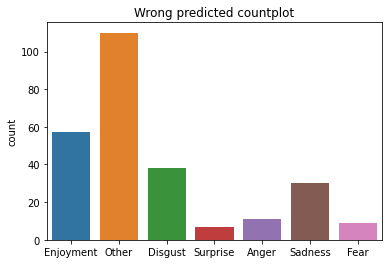

In [17]:
arr = []
arr_label = []
for i in range(len(pred_labels_trained)):
  if pred_labels_trained[i] != test_label[i]:
    arr.append(i)
    arr_label.append(pred_labels_trained[i])

convert_pred = list(map(lambda x: lb.classes_[x], arr_label))
sns.countplot(convert_pred)
plt.title('Wrong predicted countplot')